In [1]:
import pandas as pd 
import matplotlib.pyplot as plt 
from sklearn.preprocessing import StandardScaler
import numpy as np 
from pathlib import Path
import logging
import sys
from lifetimes import BetaGeoFitter, GammaGammaFitter, ParetoNBDFitter
from lifetimes.utils import summary_data_from_transaction_data
import seaborn as sns
from sklearn.metrics import mean_absolute_error, mean_squared_error
from scipy.stats import spearmanr
from math import sqrt
PROJECT_ROOT = Path.cwd().parent
sys.path.append(str(PROJECT_ROOT))

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)

# Define path
DATA_DIR = PROJECT_ROOT / "data" / "processed"

#### LOAD DATA

In [2]:
TRANSACTION = DATA_DIR / "transactions.csv"
USER_PIPELINE =  DATA_DIR / "users_pipeline.csv"

In [3]:
def load(path):
    logging.info("Loading from %s", path)
    df = pd.read_csv(path)
    if 'timestamp'in df.columns:
        df['timestamp'] = pd.to_datetime(df['timestamp'])
    if 'first_event'in df.columns:
        df['first_event'] = pd.to_datetime(df['first_event'])
    if 'last_event'in df.columns:
        df['last_event'] = pd.to_datetime(df['last_event'])
    return df
users_pipeline = load(USER_PIPELINE)
tx_df = load(TRANSACTION)

In [4]:
tx_money = tx_df.groupby(['visitorid','transactionid'], dropna=False).agg(
        monetary=('price','sum'),
        time = ('timestamp', 'max')
    ).reset_index()
tx_money = tx_money[tx_money['visitorid'].isin(users_pipeline['visitorid'])].copy()

#### FIT TO THE MODEL CLV

In [5]:
def fit_lifetimes_models_and_predict_clv(
    tx_df,
    visitor_col = 'visitorid',
    datetime_col = 'time',
    monetary_col = 'monetary',
    holdout_days = 15,
    future_days = 15,
    penalizer_coef_bgf=0.5,
    penalizer_coef_pareto=0.5,
    penalizer_coef_gamma=0.00,
):
    max_event_time = tx_df[datetime_col].max() 
    min_event_time = tx_df[datetime_col].min() 
    print("Event time range:", min_event_time, "->", max_event_time)
    calibration_end = max_event_time - pd.Timedelta(days=holdout_days)
    observation_date = calibration_end

    calib_transaction = tx_df[tx_df[datetime_col] <= calibration_end]
    df = calib_transaction.copy()

 
    df['time'] = pd.to_datetime(df['time'])
    summary = df.groupby('visitorid').agg(
        frequency=('time', lambda x: max(len(x) - 1, 0)),
        recency=('time', lambda x: (x.max() - x.min()).total_seconds() / 86400),
        T=('time', lambda x: (observation_date - x.min()).total_seconds() / 86400),
        monetary_value=(monetary_col, 'mean'),
    )
    summary = summary[summary['recency'] > 0]

    print("summary head:\n", summary.head())
    print(summary.shape[0])

    # BG/NBD 
    print("Fitting BG/NBD (BetaGeoFitter)...")
    bgf = BetaGeoFitter(penalizer_coef=penalizer_coef_bgf)
    bgf.fit(summary['frequency'], summary['recency'], summary['T'])
    print("BG/NBD params:", bgf.params_)

    # Pareto/NBD
    print("Fitting Pareto/NBD...")
    pareto = ParetoNBDFitter(penalizer_coef=penalizer_coef_pareto)
    pareto.fit(summary['frequency'], summary['recency'], summary['T'])
    print("Pareto params:", pareto.params_)

    # Gamma-Gamma monetary
    print("Fitting Gamma-Gamma (for monetary)...")
    ggf = GammaGammaFitter(penalizer_coef=penalizer_coef_gamma)
    gg_subset = summary[summary['monetary_value']>0].copy()
    ggf.fit(gg_subset['frequency'], gg_subset['monetary_value'])
    print("Gamma-Gamma params:", ggf.params_)



    summary['predicted_purchases_bgf'] = bgf.conditional_expected_number_of_purchases_up_to_time(future_days, summary['frequency'], summary['recency'], summary['T'])
    overall_avg_transaction = calib_transaction['monetary'].mean()
    predicted_avg = pd.Series(index=summary.index, dtype=float)
    mask = summary['frequency'] > 0


    predicted_avg[mask] = ggf.conditional_expected_average_profit(summary.loc[mask, 'frequency'], summary.loc[mask, 'monetary_value'])
    predicted_avg[~mask] = overall_avg_transaction
    print(overall_avg_transaction)
    print("-----------------------")
    print(ggf.conditional_expected_average_profit(summary.loc[mask, 'frequency'], summary.loc[mask, 'monetary_value']))

    summary['predicted_avg_transaction'] = predicted_avg
    summary['predicted_clv_bg_gamma'] = summary['predicted_purchases_bgf'] * summary['predicted_avg_transaction']
    print("Top predicted CLV (BG/NBD + GG):")
    print(summary[['predicted_purchases_bgf','predicted_avg_transaction','predicted_clv_bg_gamma']].describe())


    summary['predicted_purchases_pareto'] = pareto.conditional_expected_number_of_purchases_up_to_time(future_days, summary['frequency'], summary['recency'], summary['T'])
    summary['predicted_clv_pareto'] = summary['predicted_purchases_pareto'] * summary['predicted_avg_transaction']

    holdout_tx = tx_df[tx_df[datetime_col] > calibration_end]

    holdout_target = holdout_tx.groupby('visitorid').agg(future_monetary=('monetary','sum')).reset_index()
    def clv_metrics(y_true, y_pred):
        mask = y_true.notna() & y_pred.notna()

        y_true_valid = y_true[mask]
        y_pred_valid = y_pred[mask]

        # log mask
        log_mask = (y_true_valid >= 0) & (y_pred_valid >= 0)
        y_true_valid = y_true_valid[log_mask]
        y_pred_valid = y_pred_valid[log_mask]

        if len(y_true_valid) == 0:
            return None
        mape_mask = y_true_valid > 0
        if mape_mask.sum() > 0:
            mape = np.mean(
                np.abs(
                    (y_true_valid[mape_mask] - y_pred_valid[mape_mask])
                    / y_true_valid[mape_mask]
                )
            )
        else:
            mape = np.nan

        return {
            "MAE": mean_absolute_error(y_true_valid, y_pred_valid),
            "RMSE": sqrt(mean_squared_error(y_true_valid, y_pred_valid)),
            "Spearman": spearmanr(y_true_valid, y_pred_valid).correlation,
            "MAE_log1p": mean_absolute_error(
                np.log1p(y_true_valid),
                np.log1p(y_pred_valid)
            ),
            "MAPE": mape,
            "n_eval": len(y_true_valid)
        }


    eval_df = summary.reset_index().merge(
        holdout_target,
        on=visitor_col,
        how='left'
    )

    metrics_bg = clv_metrics(
        eval_df['future_monetary'],
        eval_df['predicted_clv_bg_gamma']
    )

    metrics_pareto = clv_metrics(
        eval_df['future_monetary'],
        eval_df['predicted_clv_pareto']
    )

    print("BG/NBD + GG metrics:")
    if metrics_bg is not None and metrics_pareto is not None:
        for k, v in metrics_bg.items():
            print(f"{k}: {v:.4f}")

        print("\nPareto/NBD metrics:")
        for k, v in metrics_pareto.items():
            print(f"{k}: {v:.4f}")

    models = {
        "bgf": bgf,
        "pareto": pareto,
        "ggf": ggf
    }
    metrics = {
        "bgf_gg" : metrics_bg,
        "pareto_gg" : metrics_pareto
    }
    return eval_df, models, metrics


In [6]:
features, models, metrics = fit_lifetimes_models_and_predict_clv(tx_money)

Event time range: 2015-05-03 04:56:06.224000 -> 2015-09-18 02:43:12.017000
summary head:
            frequency    recency           T  monetary_value
visitorid                                                  
3926               1  14.193558   92.278646    44100.000000
5042               2   0.021983   52.412786    47720.000000
6699               3   0.211585  118.200706    52683.333333
8043               1   3.043567   16.268070    29880.000000
8731               1   0.093017   77.330010   263880.000000
936
Fitting BG/NBD (BetaGeoFitter)...
BG/NBD params: r        0.239185
alpha    0.005015
a        0.276242
b        0.111954
dtype: float64
Fitting Pareto/NBD...
Pareto params: r        0.477926
alpha    0.157854
s        1.091321
beta     1.751583
dtype: float64
Fitting Gamma-Gamma (for monetary)...
Gamma-Gamma params: p         1.088898
q         4.142833
v    454312.045259
dtype: float64
156596.46411994722
-----------------------
visitorid
3926       128250.089550
5042       112509.

In [7]:
def plot_predicted_clv_distributions(
    summary,
    bg_col='predicted_clv_bg_gamma',
    pareto_col='predicted_clv_pareto'
):
    plt.figure(figsize=(12, 5))
    sns.kdeplot(
        np.log1p(summary[bg_col].clip(lower=0)),
        label='BG/NBD + Gamma-Gamma (log1p)',
        lw=2
    )
    sns.kdeplot(
        np.log1p(summary[pareto_col].clip(lower=0)),
        label='Pareto/NBD (log1p)',
        lw=2
    )

    plt.legend()
    plt.title("Predicted CLV Distribution (log1p)")
    plt.xlabel("log1p(CLV)")
    plt.ylabel("Density")
    plt.show()

def plot_true_vs_predicted_clv(
    eval_df,
    true_col='future_monetary',
    bg_col='predicted_clv_bg_gamma',
    pareto_col='predicted_clv_pareto',
    model='both'   # 'bg', 'pareto', 'both'
):
    import numpy as np
    import matplotlib.pyplot as plt

    plt.figure(figsize=(12, 8))
    plotted_vals = []

    def plot_model(y_true, y_pred, label):
        mask = (
            y_true.notna() & y_pred.notna()
            & (y_true >= 0) & (y_pred >= 0)
        )
        y_true_log = np.log1p(y_true[mask])
        y_pred_log = np.log1p(y_pred[mask])

        plt.scatter(y_true_log, y_pred_log, alpha=0.3, label=label)
        plotted_vals.extend([y_true_log, y_pred_log])

        std = np.std(y_pred_log - y_true_log)
        return std
    stds = []
    if model in ['bg', 'both']:
        std_bg = plot_model(
            eval_df[true_col],
            eval_df[bg_col],
            'BG/NBD + Gamma-Gamma'
        )
        stds.append(std_bg)

    if model in ['pareto', 'both']:
        std_p = plot_model(
            eval_df[true_col],
            eval_df[pareto_col],
            'Pareto/NBD'
        )
        stds.append(std_p)

    if not plotted_vals:
        print("No valid data to plot.")
        return
    min_val = min(v.min() for v in plotted_vals)
    max_val = max(v.max() for v in plotted_vals)
    x = np.linspace(min_val, max_val, 200)
    std_line = np.mean(stds)

    plt.plot(x, x, 'r--', linewidth=2, label='45° line')
    plt.plot(x, x + std_line, 'r:', linewidth=1.5, label='+1 STD')
    plt.plot(x, x - std_line, 'r:', linewidth=1.5, label='-1 STD')

    plt.xlabel('log1p(True Future Monetary)')
    plt.ylabel('log1p(Predicted CLV)')
    plt.title('True vs Predicted CLV (log1p) with ±1 STD')
    plt.legend()
    plt.show()


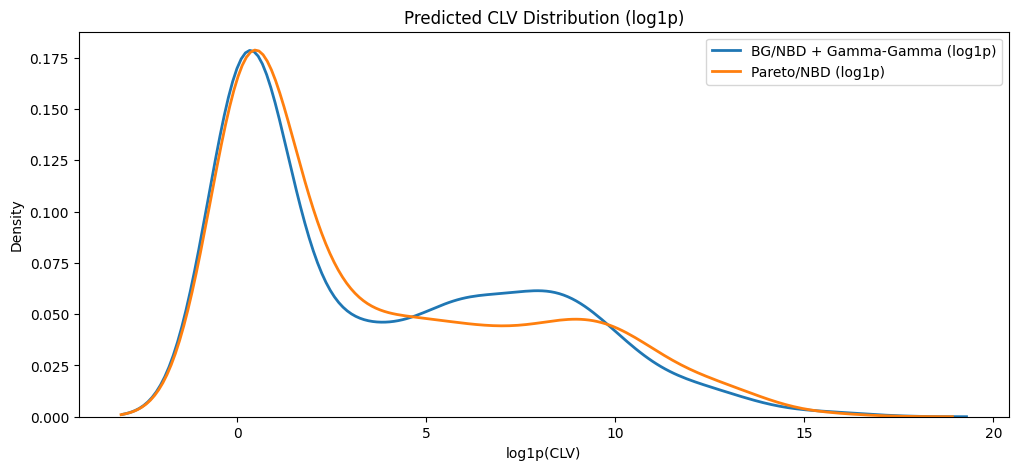

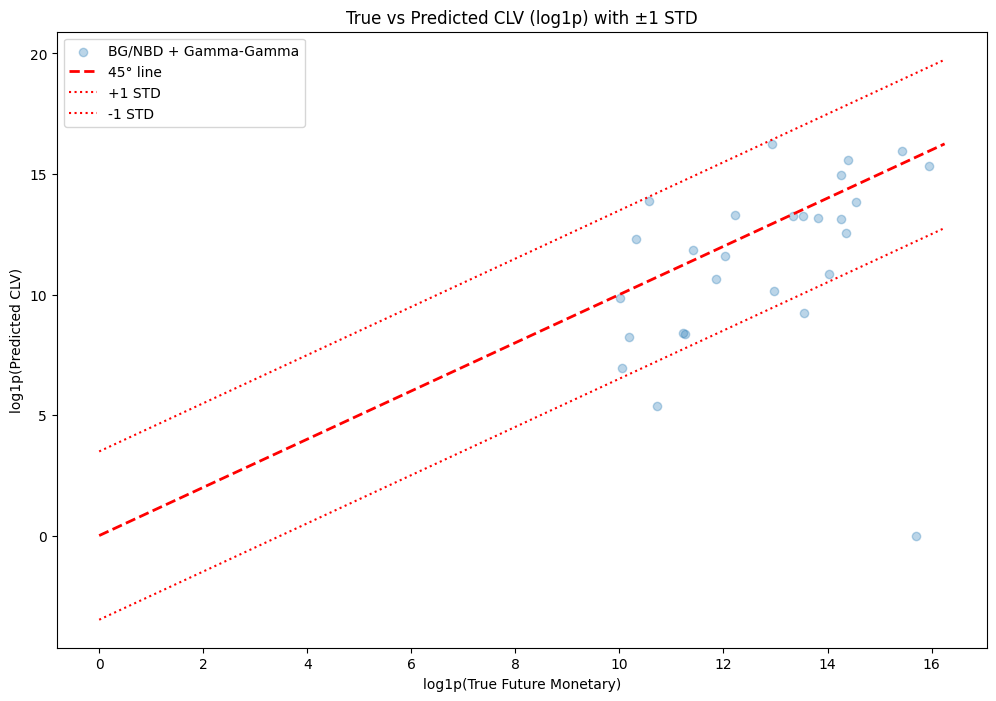

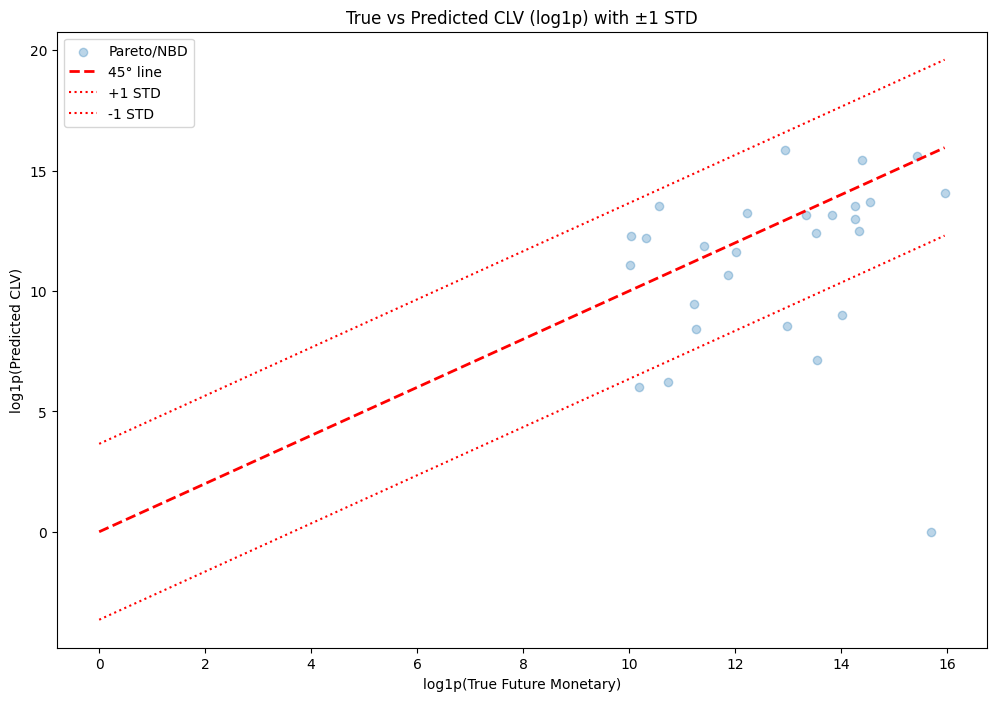

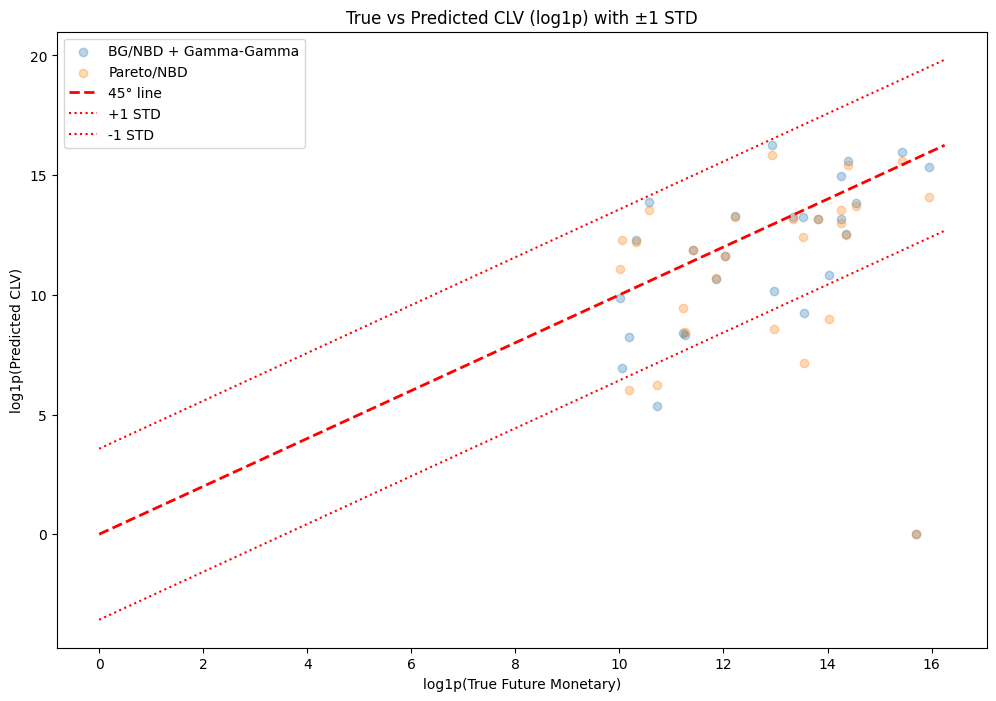

In [8]:
plot_predicted_clv_distributions(features)
plot_true_vs_predicted_clv(features, model = 'bg')
plot_true_vs_predicted_clv(features, model = 'pareto')
plot_true_vs_predicted_clv(features, model = 'both')

#### FIT TO THE ENTIRE DATASET FOR THE FUTURE PIPELINE

In [9]:
features, models, metrics = fit_lifetimes_models_and_predict_clv(tx_money, holdout_days=0, future_days= 30)

Event time range: 2015-05-03 04:56:06.224000 -> 2015-09-18 02:43:12.017000
summary head:
            frequency    recency           T  monetary_value
visitorid                                                  
3926               1  14.193558  107.278646    44100.000000
4537               1   0.304216   11.357676    77988.000000
5042               2   0.021983   67.412786    47720.000000
6699               3   0.211585  133.200706    52683.333333
8043               1   3.043567   31.268070    29880.000000
1031
Fitting BG/NBD (BetaGeoFitter)...
BG/NBD params: r        0.235463
alpha    0.005166
a        0.282999
b        0.116311
dtype: float64
Fitting Pareto/NBD...
Pareto params: r        0.469611
alpha    0.167302
s        1.139246
beta     2.159005
dtype: float64
Fitting Gamma-Gamma (for monetary)...
Gamma-Gamma params: p         1.148365
q         3.279021
v    322245.049576
dtype: float64
158739.59329927427
-----------------------
visitorid
3926       122745.966383
4537       134100

In [10]:
features = features[['visitorid', 'predicted_avg_transaction','predicted_clv_bg_gamma','predicted_purchases_bgf']]
users = users_pipeline.merge(
    features,
    on = 'visitorid',
    how = 'left'
)


In [11]:
users.head()

,Unnamed: 0,visitorid,total_events,first_event,last_event,recency_days,tenure_days,total_views,total_addtocarts,total_tx,...,active_days,events_per_active_day,view_price,addtocart_price,tx_price,avg_inter_event_days,business_label,predicted_avg_transaction,predicted_clv_bg_gamma,predicted_purchases_bgf
0,3926,3926,13,2015-06-02 19:44:15.832,2015-08-18 20:41:30.407,30,78,8,3,3,...,3,4.333333,25110.0,16600.0,29400.0,5.926131,At Risk,122745.966383,1310.135500,1.067355e-02
1,4537,4537,10,2015-05-14 01:23:42.959,2015-09-07 01:26:13.013,11,117,5,3,2,...,3,3.333333,64190.4,77988.0,77988.0,12.889077,At Risk,134100.331110,1536.451779,1.145748e-02
2,5042,5042,13,2015-07-12 16:23:12.305,2015-07-12 17:46:39.453,67,1,7,3,3,...,1,13.000000,24480.0,18360.0,18360.0,0.004823,Potential Loyalists,104825.387057,0.009852,9.398102e-08
3,6699,6699,104,2015-05-07 21:30:27.547,2015-05-08 03:01:06.009,132,1,92,8,4,...,2,52.000000,NaN,NaN,NaN,0.002223,Loyal Customers,96356.189166,0.000481,4.991540e-09
4,8043,8043,10,2015-07-21 23:46:29.406,2015-08-20 21:48:51.263,28,30,6,2,2,...,3,3.333333,23620.0,29880.0,29880.0,3.324250,At Risk,117981.475519,2708.549366,2.295741e-02


In [12]:
users.to_csv(USER_PIPELINE, index = False)